In [1]:
import pandas as pd
import numpy as np
from scipy.linalg import svd
from tqdm import tqdm
import pickle
import os
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import csr_matrix
from sklearn.pipeline import Pipeline
### NLTK Preprocessing
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
# nltk.download('wordnet')
from nltk.corpus import stopwords
StopWords = set(stopwords.words('english'))

main_path = "C:/Users/mustafa/Desktop/SEM6/CS6370-NLP/A1/cranfield/"

from sys import version_info
import argparse
import json
import matplotlib.pyplot as plt

"""
-----------------------------------------------------------------------------------------
Loading Documents
-----------------------------------------------------------------------------------------
"""

queries_json = json.load(open(main_path + "cran_queries.json", 'r'))[:]
query_ids, queries = [item["query number"] for item in queries_json], [item["query"] for item in queries_json]

# Read documents
docs_json = json.load(open(main_path + "cran_docs.json", 'r'))[:]
doc_ids, docs = [item["id"] for item in docs_json], [item["body"] for item in docs_json]
authors, bibs, titles = [item["author"] for item in docs_json], [item["bibliography"] for item in docs_json], [item["title"] for item in docs_json]

### to resolve num1 discrepancy:
query_ids = list(np.array(query_ids)-1)
doc_ids = list(np.array(doc_ids)-1) 

In [2]:
"""
-----------------------------------------------------------------------------------------
Master corpus
-----------------------------------------------------------------------------------------
"""

from native_preprocessor import native_prep
native_prep = native_prep()

proc_queries = native_prep.preprocessQueries(queries)
proc_docs = native_prep.preprocessDocs(docs)
proc_authors = native_prep.preprocessQueries(authors)
proc_titles = native_prep.preprocessQueries(titles)

# print(proc_authors)
master_corpus = proc_authors + proc_docs + proc_titles

""" To build master vocabulary for TFIDF vectorizer """
def create_vocab(corpus):
    vocab = []
    for doc in corpus:
        for sent in doc:
            for w in sent:
                if w not in vocab:
                    vocab.append(w)
    return vocab

master_vocab = create_vocab(master_corpus)
# print(len(master_vocab))


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\mustafa\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mustafa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
"""
-----------------------------------------------------------------------------------------
Building indexes
-----------------------------------------------------------------------------------------
"""
vectorizer = TfidfVectorizer(stop_words=StopWords, ngram_range=(1,1), vocabulary=master_vocab, smooth_idf=True)

# norm_doct = vectorizer.fit_transform(docs).toarray().T
norm_titles = vectorizer.fit_transform(titles).toarray().T
norm_qt = vectorizer.transform(queries).toarray().T
norm_authors = vectorizer.transform(authors).toarray().T

norm_combined = 1*norm_titles  + 1*norm_authors

proc_queries = [vectorizer.build_analyzer()(query) for query in queries]                                                 
# print(proc_queries[0])
proc_docs = [vectorizer.build_analyzer()(doc) for doc in docs]                                                 
# print(proc_docs[0])
proc_titles = [vectorizer.build_analyzer()(title) for title in titles]                                                 
# print(proc_titles[0])

# print(norm_qt.shape)
# print(norm_doct.shape)
# print(norm_combined.shape)

In [4]:
"""
-----------------------------------------------------------------------------------------
Ranking
-----------------------------------------------------------------------------------------
"""
def ranking(norm_qt, norm_doct, k):
    """produces the top k relevant documents per query"""  
    """Ranking by cosine sim and argsort, then picking top 3 relevant docs"""    
    cosine_sim_matrix = norm_qt.T@norm_doct
    ind = np.argsort(cosine_sim_matrix, axis=1)
    
    best_match = np.fliplr(ind[:, -k:])
    ind_list = best_match.tolist()

    return ind_list

doc_ids_ordered = ranking(norm_qt, norm_combined, 10)

### Eval

In [5]:
qrels = json.load(open(main_path + "cran_qrels.json", 'r'))[:]

from big_true_IDs import big_true_IDs
big_true_IDs_ob = big_true_IDs()
big_true_IDs = big_true_IDs_ob.big_true_IDs(qrels)     

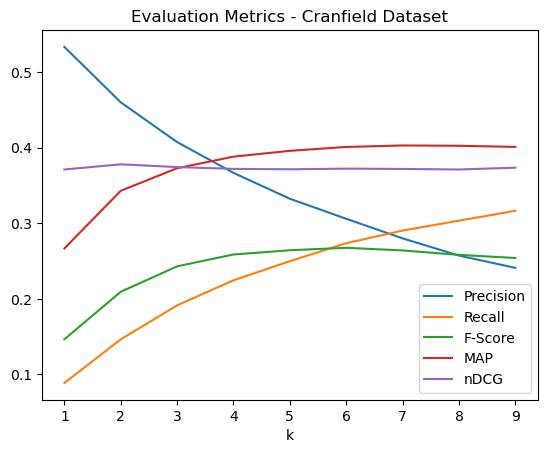

In [6]:
query_ids = list(range(225))


from plotting import plotting
plot_ob = plotting()
plot_ob.plot_measures(doc_ids_ordered, query_ids, big_true_IDs, qrels, 10)

In [55]:
from check_matches import Check_matches
check_matches = Check_matches()

bqi = check_matches.check_queries(doc_ids_ordered, query_ids, big_true_IDs, qrels, 10)
print("------------------------------------------------")
print(len(bqi))
print(bqi)
print("------------------------------------------------")
query_index = check_matches.create_query_index(proc_queries)
doc_index = check_matches.create_doc_index(proc_docs)
# check_matches.display_query_match(bqi, query_index, doc_ids_ordered, doc_index)

------------------------------------------------
24
[17, 21, 26, 27, 35, 43, 62, 68, 71, 78, 79, 84, 86, 96, 116, 140, 141, 150, 151, 166, 174, 180, 198, 215]
------------------------------------------------
